In [83]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed_3/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16
MAX_LEN = 200

# -------------------------------- load data ---------------------------------------
f = h5py.File(pred_file, 'r')
preds = np.array(f['main']).astype('float32')
g = h5py.File(gt_seg,'r')
gt_seg = g['main']
print preds.shape

(3, 432, 432, 432)


# Divide Volumes, set up args

In [84]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_vll/'
dims = np.array(preds.shape[1:])
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
# num_vols[0] = 2 # delete this!
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts,ends = [],[]
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas - [3,3,3] +3*np.array([x==0,y==0,z==0]))
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra +[3,3,3])
args = []
for i in range(len(starts)):
    s,e = starts[i],ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print i,s,e,pred_vol.shape
    args.append((pred_vol,out_folder+dim_to_name(s)))    

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]
0 [0 0 0] [148 148 148] (3, 148, 148, 148)
1 [  0   0 141] [148 148 292] (3, 148, 148, 151)
2 [  0   0 285] [148 148 439] (3, 148, 148, 147)
3 [  0 141   0] [148 292 148] (3, 148, 151, 148)
4 [  0 141 141] [148 292 292] (3, 148, 151, 151)
5 [  0 141 285] [148 292 439] (3, 148, 151, 147)
6 [  0 285   0] [148 439 148] (3, 148, 147, 148)
7 [  0 285 141] [148 439 292] (3, 148, 147, 151)
8 [  0 285 285] [148 439 439] (3, 148, 147, 147)
9 [141   0   0] [292 148 148] (3, 151, 148, 148)
10 [141   0 141] [292 148 292] (3, 151, 148, 151)
11 [141   0 285] [292 148 439] (3, 151, 148, 147)
12 [141 141   0] [292 292 148] (3, 151, 151, 148)
13 [141 141 141] [292 292 292] (3, 151, 151, 151)
14 [141 141 285] [292 292 439] (3, 151, 151, 147)
15 [141 285   0] [292 439 148] (3, 151, 147, 148)
16 [141 285 141] [292 439 292] (3, 151, 147, 151)
17 [141 285 285] [292 439 439] (3, 151, 147, 147)
18 [285   0   0] [439 148 148] (3, 147, 148, 148)
19 [285  

# Call Watershed

In [85]:
def zwshed_h5_par(arg):
    (pred_vol,seg_save_path) = arg
    zwatershed_basic_h5(pred_vol,seg_save_path)
    print "finished",seg_save_path,"watershed"
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)
# zwshed_h5_par(args[0])

finished /nobackup/turaga/singhc/par_zwshed_3/0_0_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_141_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_141_141_vll/ watershed
finished /nobackup

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Stitch

i,x,y,z 0 0 0 0
i,x,y,z 1 0 0 1
	merging numbers, 183 keys ... 
	before nsegs= 26638 num0= 3116661
	after nsegs= 26604 num0= 3116661
rg_i 0
rg_i

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 1
	renumbering all... 26604 num0= 3116661
i,x,y,z 3 0 1 0
i,x,y,z 4 0 1 1
	merging numbers, 369 keys ... 
	before nsegs= 43820 num0= 3182027
	after nsegs= 43773 num0= 3182027
rg_i 3
rg_i 4
	renumbering all... 43773 num0= 3182027
	merging numbers, 771 keys ... 
	before nsegs= 68593 num0= 15102238
	after nsegs= 68455 num0= 15102238


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


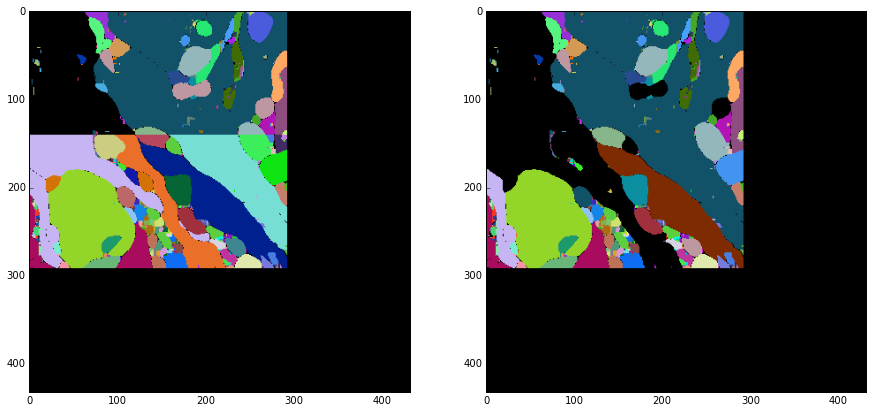

rg_i 0
rg_i 1
rg_i 3
rg_i 4
	renumbering all... 68455 num0= 15102238


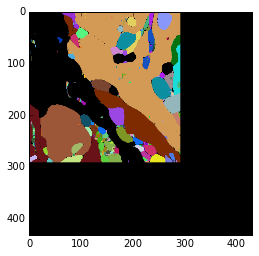

	merging numbers, 0 keys ... 
	before nsegs= 68455 num0= 68103454
	after nsegs= 68455 num0= 68103454
rg_i 0
rg_i 1
rg_i 3
rg_i 4
	renumbering all... 68455 num0= 68103454
finished


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [181]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
COUNT_THRESH = 0
filename = 'basic.h5'
seg_out = np.zeros(dims,dtype='uint64')
counts_x = {}
rg_fulls, rg_counts_fulls = {},{}
X,Y,Z = (1,2,2)
x_range,y_range,z_range = [],[],[]
for x in range(X): #num_vols[0]):
    ix = x*num_vols[1]*num_vols[2]
    sx,ex,re_x = starts[ix],ends[ix],{}
    
    # start ybar --------------------------------------------------
    xdim = deltas[0]+7
    if x==0:
        xdim = deltas[0]+4
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')
    counts_y = {}

    for y in range(Y): #num_vols[1]):
        iy = x*num_vols[1]*num_vols[2]+y*num_vols[2]
        sy,ey,re_y = starts[iy], ends[iy], {}
        
        # start zbar -----------------------------------------------
        ydim = deltas[1]+7
        if y==0:
            ydim = deltas[1]+4
        if y==num_vols[1]-1:
            ydim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        
        counts_z = {}
        for z in range(Z): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e,re_z = args[i],starts[i],ends[i],{}
            basic_file = h5py.File(arg[1]+filename,'r')
            seg = np.array(basic_file['seg'])
            rg = np.array(basic_file['rg'])
            rg_counts = np.array(basic_file['counts'])
            inc = np.max(zbar)+1
            seg[seg!=0]+=inc
            rg[:,:2] += inc
            rg_fulls[i] = rg
            rg_counts_fulls[i]=rg_counts
            print "i,x,y,z",i,x,y,z
            if not z==0:
                re_z = calc_renums(edge_mins=zbar[:,:,s[2]+3],edge_maxes=seg[:,:,3], re=re_z, counts=counts_z)
            zbar[:,:,s[2]:e[2]] = seg[:,:,:]
        z_range = range(iy,iy+Z)
        zbar,rg_fulls,rg_counts = merge_and_renum(re_z,zbar,rg_fulls,rg_counts,z_range,p=False,counts=counts_z)
        zbar[zbar!=0] += np.max(ybar)+1
        y_range += z_range
        # end zbar --------------------------------------------------    
        
        if not y==0: 
            re_y = calc_renums(edge_mins=ybar[0:,s[1]+3,:],edge_maxes=zbar[0:,3,:], re=re_y, counts=counts_y)
        ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]

    ybar,rg_fulls,rg_counts = merge_and_renum(re_y,ybar,rg_fulls,rg_counts,y_range,p=True,counts=counts_y)
    ybar[ybar!=0] += np.max(seg_out)+1
    x_range += y_range

    # end ybar -------------------------------------------------------
    if not x==0:
        re_x = calc_renums(edge_mins=seg_out[sx[0]+3,:,:],edge_maxes=ybar[3,:,:],re=re_x, counts=counts_x)
    seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
    seg_out,rg_fulls,rg_counts = merge_and_renum(re_x,seg_out,rg_fulls,rg_counts,x_range,p=False,counts=counts_x)

print "finished"
# display_seg_xy(seg_out)

In [176]:
# stitch methods
def calc_renums(edge_mins,edge_maxes, re, counts={}):
    edge_mins = edge_mins.ravel()
    edge_maxes = edge_maxes.ravel()
#     print "edge_mins",edge_mins
#     print "edge_maxes",edge_maxes
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min==0 and not edge_max==0:
            if not edge_max==edge_min:
                if edge_max in re: # already in map
                    old_min = re[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        re[merge_max] = merge_min
                        add_or_inc(merge_max,merge_min,counts)
            re[edge_max] = edge_min
            add_or_inc(edge_max,edge_min,counts)
    return re
    
def prune_and_renum(seg,sizeThreshold=1):
    segId = np.unique(seg)
    renum = np.zeros(segId.max()+1,dtype=np.uint64)
    renum[segId] = np.arange(1,len(segId)+1)
    renum[0]=0
    return renum[seg]

def add_or_inc(key_max,key_min,d):
    key = (key_max,key_min)
    if not key in d:
        d[key] = 1
    else:
        d[key] +=1
    
def merge_and_renum(renums,zbar,rg_fulls,rg_counts,rg_indexes,p=False,counts={}):
    # only keep strongest edges
    renums = {}
    count_maxes = {}
    for pair in counts:
        count = counts[pair]
        e1,e2 = pair
        if e1 in renums:
            if count > count_maxes[e1]:
                renums[e1] = e2
                count_maxes[e1] = count
        else:
            renums[e1] = e2
            count_maxes[e1] = count
    
    # calculate merges
    sum_counts = 0
    for key in counts:
        sum_counts += counts[key]
    renums2 = {}
    print "\tmerging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        if counts[(key,val)] > COUNT_THRESH:
            while val in renums:
                val = renums[val]
            renums2[key] = val
            
    # merge segs
    print "\tbefore nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        fig = plt.figure(figsize=(15, 7))
        plt.subplot(1,2,1)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
    mp[renums2.keys()] = renums2.values()
    zbar = mp[zbar]
    print "\tafter nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        plt.subplot(1,2,2)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    plt.show()
    
    # merge rg, counts
    for rg_i in rg_indexes:
        print "rg_i",rg_i
        rg_ = rg_fulls[rg_i]
        counts_ = rg_fulls[rg_i]
        min_rg = np.min(rg_)
        max_rg = np.max(rg_)
        for key in renums2:
            val = renums[key]
            if min_rg < key and key < max_rg: 
                if min_rg < val and val < max_rg: # both in this subvol
                    for r in range(rg_.shape[0]):
                        pass
#                         if r[0]==
                else: # only key in this subvol
                    pass
            if min_rg < val and val < max_rg: # only val in this subvol
#                 counts_[val] += 
                pass
    
    # renumber
    zbar = prune_and_renum(zbar,2)
    print "\trenumbering all...",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        plt.imshow(zbar[0, :, :], cmap=cmap)
    plt.show()

    return zbar, rg_fulls, rg_counts

# Visualize

In [116]:
def display_affs(raw):
    plt.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def display_seg_xy(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[:, :, depth], cmap=cmap)
    plt.show()

In [189]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])
y = np.arange(1,10)
x2 = np.delete(x,1,0)
y2 = np.delete(y,5)
print x
print x2
print y
print y2

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [7 8 9]]
[1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 7 8 9]


In [195]:
rg = np.array(basic_file['rg'])
print sum(rg[:,0]<rg[:,1])

89776
